In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings

In [33]:
house_price_train_final = pd.read_csv('Data/house_price_train_final.csv')
house_price_train_final.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,GarageFinish_Unf,KitchenQual_TA,ExterQual_TA,SalePrice
0,7,1710,2,548,856,856,2,8,2003,2003,False,False,False,208500
1,6,1262,2,460,1262,1262,2,6,1976,1976,False,True,True,181500
2,7,1786,2,608,920,920,2,6,2001,2002,False,False,False,223500
3,7,1717,3,642,756,961,1,7,1915,1970,True,False,True,140000
4,8,2198,3,836,1145,1145,2,9,2000,2000,False,False,False,250000


In [34]:
X = house_price_train_final.drop('SalePrice', axis=1)
y = house_price_train_final['SalePrice']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [37]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=42),
    'Lasso Regression': Lasso(random_state=42),
    'ElasticNet': ElasticNet(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}
results = {}



In [38]:
# Evaluar cada modelo con validación cruzada
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-cv_scores)
    results[name] = {
        'RMSE CV': rmse_scores.mean(),
        'RMSE Std': rmse_scores.std()
    }
    print(f"{name}: RMSE = {rmse_scores.mean():.2f} (±{rmse_scores.std():.2f})")


Linear Regression: RMSE = 38317.09 (±7602.27)
Ridge Regression: RMSE = 38308.38 (±7587.28)
Lasso Regression: RMSE = 38316.89 (±7601.63)
ElasticNet: RMSE = 38724.17 (±5982.53)
Random Forest: RMSE = 33302.56 (±5795.84)
Gradient Boosting: RMSE = 31890.55 (±5408.78)


In [39]:

# Encontrar el mejor modelo basado en RMSE
best_model_name = min(results, key=lambda x: results[x]['RMSE CV'])
print(f"\nEl mejor modelo es: {best_model_name}")


El mejor modelo es: Gradient Boosting


In [40]:

# Optimizar hiperparámetros del mejor modelo
if best_model_name == 'Linear Regression':
    best_model = LinearRegression()
    param_grid = {}
elif best_model_name == 'Ridge Regression':
    best_model = Ridge(random_state=42)
    param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
elif best_model_name == 'Lasso Regression':
    best_model = Lasso(random_state=42)
    param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]}
elif best_model_name == 'ElasticNet':
    best_model = ElasticNet(random_state=42)
    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1.0],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    }
elif best_model_name == 'Random Forest':
    best_model = RandomForestRegressor(random_state=42)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }
else:  # Gradient Boosting
    best_model = GradientBoostingRegressor(random_state=42)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7]
    }

In [41]:

# Realizar búsqueda de hiperparámetros si hay parámetros para optimizar
if param_grid:
    print(f"\nOptimizando hiperparámetros para {best_model_name}...")
    grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    best_params = grid_search.best_params_
    print(f"Mejores parámetros: {best_params}")
    final_model = grid_search.best_estimator_
else:
    print(f"\nEntrenando modelo final {best_model_name}...")
    best_model.fit(X_train_scaled, y_train)
    final_model = best_model


Optimizando hiperparámetros para Gradient Boosting...
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [42]:

# Evaluar el modelo final
y_pred = final_model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nResultados del modelo final ({best_model_name}):")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")



Resultados del modelo final (Gradient Boosting):
RMSE: 29036.89
R²: 0.8901


In [43]:

# Visualizar residuos
residuos = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuos, alpha=0.5)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='--')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Residuos vs Predicciones')
plt.savefig('residuos.png')
plt.close()

In [44]:
plt.figure(figsize=(10, 6))
sns.histplot(residuos, kde=True)
plt.xlabel('Residuos')
plt.title('Distribución de residuos')
plt.savefig('distribucion_residuos.png')
plt.close()

In [45]:

# Si el mejor modelo permite análisis de importancia de características
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    # Obtener importancia de características
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': final_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Visualizar las 15 características más importantes
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title('15 características más importantes')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.close()
    
    print("\nCaracterísticas más importantes:")
    print(feature_importance.head(10))


Características más importantes:
             Feature  Importance
0        OverallQual    0.548688
1          GrLivArea    0.174629
4        TotalBsmtSF    0.074331
2         GarageCars    0.045252
5           1stFlrSF    0.043900
9       YearRemodAdd    0.032628
8          YearBuilt    0.027084
10  GarageFinish_Unf    0.019325
3         GarageArea    0.013267
6           FullBath    0.009936


In [48]:

# Cargar datos de prueba y hacer predicciones para enviar
try:
    # Cargar datos de prueba
    house_price_test = pd.read_csv('Data/test.csv')
    
    # Procesar los datos de prueba de la misma manera que los datos de entrenamiento
    
    # Primero, maneja las columnas que se eliminaron durante el entrenamiento
    cols_to_drop = ['Id'] + [col for col in house_price_test.columns if col not in X.columns and col != 'Id']
    house_price_test_processed = house_price_test.drop(columns=cols_to_drop, errors='ignore')
    
    # Manejar valores faltantes en columnas numéricas
    for col in house_price_test_processed.select_dtypes(include=['float64', 'int64']).columns:
        if house_price_test_processed[col].isna().sum() > 0:
            # Usar la mediana para imputar valores numéricos faltantes
            house_price_test_processed[col] = house_price_test_processed[col].fillna(house_price_test_processed[col].median())
    
    # Manejar valores faltantes en columnas categóricas
    for col in house_price_test_processed.select_dtypes(include=['object']).columns:
        if house_price_test_processed[col].isna().sum() > 0:
            # Usar el modo para imputar valores categóricos faltantes
            house_price_test_processed[col] = house_price_test_processed[col].fillna(house_price_test_processed[col].mode()[0])
    
    # Codificar variables categóricas
    house_price_test_encoded = pd.get_dummies(house_price_test_processed, drop_first=True)
    
    # Asegurar que el conjunto de prueba tenga las mismas columnas que el de entrenamiento
    for col in X.columns:
        if col not in house_price_test_encoded.columns:
            house_price_test_encoded[col] = 0
    
    # Mantener solo las columnas utilizadas en el entrenamiento
    house_price_test_final = house_price_test_encoded[X.columns]
    
    # Verificar que no hay valores NaN
    assert not house_price_test_final.isna().any().any(), "Aún hay valores NaN en los datos procesados"
    
    # Escalar los datos
    house_price_test_scaled = scaler.transform(house_price_test_final)
    
    # Hacer predicciones
    test_predictions = final_model.predict(house_price_test_scaled)
    
    # Crear el formato de envío
    submission = pd.DataFrame({
        'Id': house_price_test['Id'],
        'SalePrice': test_predictions
    })
    
    # Guardar el archivo de envío
    submission.to_csv('submission.csv', index=False)
    print("\nArchivo de envío creado como 'submission.csv'")
except Exception as e:
    print(f"\nNo se pudieron generar predicciones para el conjunto de prueba: {e}")
    print("Nota: Para generar predicciones, asegúrate de que los datos de prueba estén preprocesados correctamente.")


Archivo de envío creado como 'submission.csv'


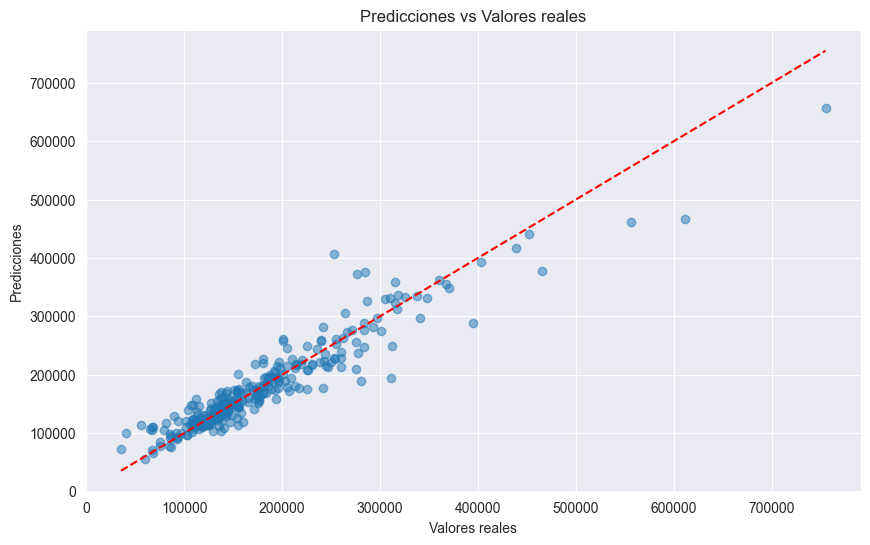

In [50]:
# analizar el rendimiento del modelo final
# Comparar predicciones con valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores reales')
plt.savefig('predicciones_vs_reales.png')
plt.show()